In [1]:
### Code written by Adhika
### Last modified Apr,30 2023 by Fandi

#Read data from CT_Time.dat, and plot time histories of CT and CP
Input_File = "ct_time.dat"

Reading Data
Plotting (Raw) Data
Initial time =  0.10025
Total time =  274.8902588


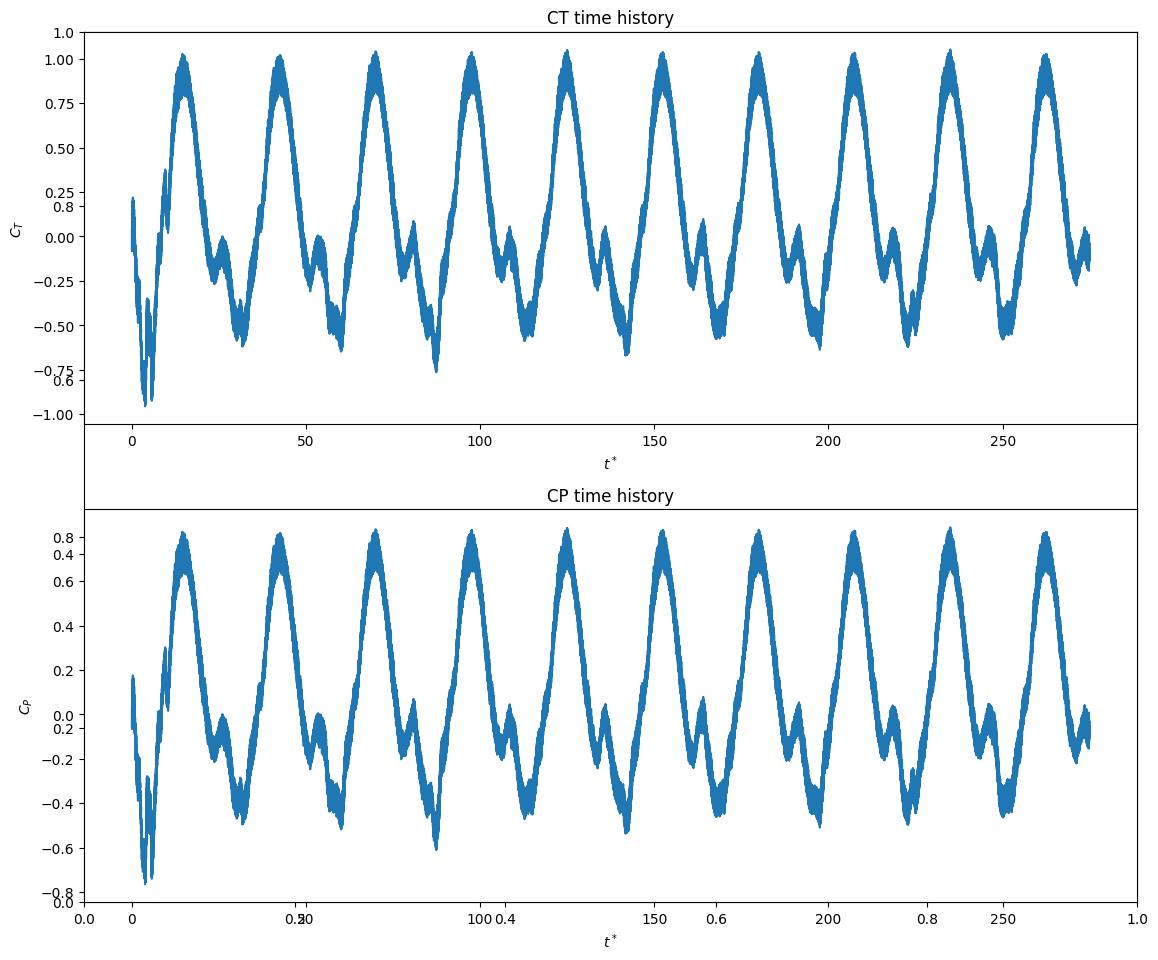

In [2]:
### Code written by Adhika
### Last modified Apr,30 2023 by Fandi

#Read data from CT_Time.dat, and plot time histories of CT and CP

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

print("Reading Data")
Time_Data = np.loadtxt(Input_File, usecols=0, skiprows=2, unpack=True)
CT_Data = np.loadtxt(Input_File, usecols=2, skiprows=2, unpack=True)
CP_Data = np.loadtxt(Input_File, usecols=3, skiprows=2, unpack=True)
Total_Data = len(Time_Data)

print("Plotting (Raw) Data")
print("Initial time = ",Time_Data[0])
print("Total time = ",Time_Data[Total_Data-1])
plt.subplots(figsize=(12, 10))

plt.subplot(2, 1, 1)  # row 1, column 2, count 1
plt.plot(Time_Data, CT_Data)
plt.title('CT time history')
plt.xlabel('$t^*$')
plt.ylabel('$C_T$')    

plt.subplot(2, 1, 2)
plt.plot(Time_Data, CP_Data)
plt.title('CP time history')
plt.xlabel('$t^*$')
plt.ylabel('$C_P$')

plt.tight_layout()
plt.savefig("CT_CP_Raw.png", bbox_inches='tight', dpi=300)
plt.show()

In [3]:
#Calculate the mean values with a progressive interval from Start_Time
#Plot the mean values wrt. the time interval from Start_Time.
Start_Time = 0

Processing Data: 100%|██████████████| 1099160/1099160 [05:07<00:00, 3577.73it/s]


Saving Data
Plotting Data


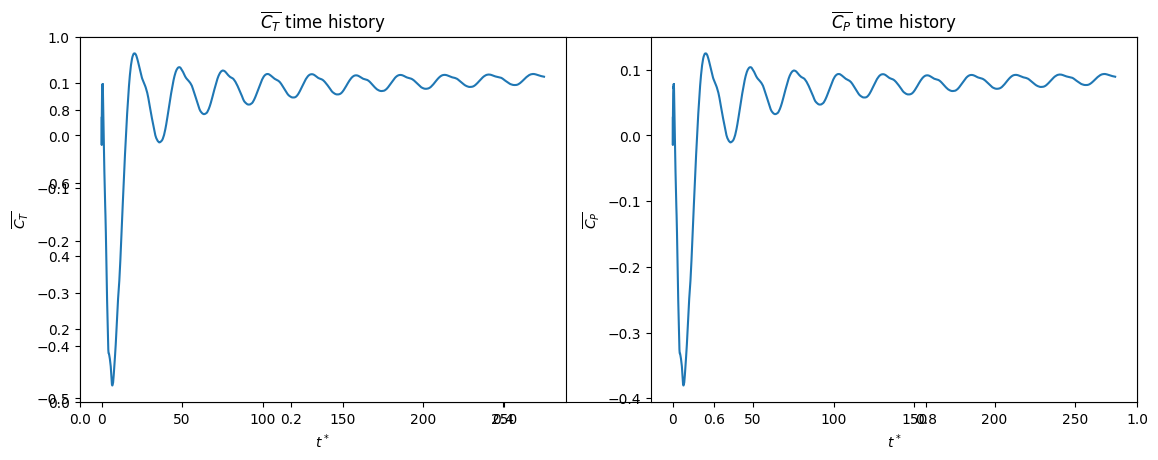

Final CT average =  0.11173879431074639
Final CP average =  0.089391035441428


In [4]:
#Calculate the mean values with a progressive interval from Start_Time
#Plot the mean values wrt. the time interval from Start_Time.


Start_Index = 0
while Time_Data[Start_Index] < Start_Time:
    Start_Index += 1

CT_Avg =[]
CP_Avg =[]
for i in tqdm(range(Start_Index + 1, Total_Data),desc="Processing Data"):
#for i in range(Start_Index + 1, Total_Data):
    CT_Avg.append(np.mean(CT_Data[Start_Index:i]))
    CP_Avg.append(np.mean(CP_Data[Start_Index:i]))

    
CT_Avg = np.asarray(CT_Avg)
CP_Avg = np.asarray(CP_Avg)
print("Saving Data")
np.savetxt("CT_Avg.txt", CT_Avg, delimiter='\t')
np.savetxt("CP_Avg.txt", CP_Avg, delimiter='\t')

print("Plotting Data")
plt.subplots(figsize=(12, 5))

plt.subplot(1, 2, 1)  # row 1, column 2, count 1
plt.plot(Time_Data[Start_Index + 1:Total_Data], CT_Avg)
plt.title('$\overline{C_T}$ time history')
plt.xlabel('$t^*$')
plt.ylabel('$\overline{C_T}$')    

plt.subplot(1, 2, 2)
plt.plot(Time_Data[Start_Index + 1:Total_Data], CP_Avg)
plt.title('$\overline{C_P}$ time history')
plt.xlabel('$t^*$')
plt.ylabel('$\overline{C_P}$')

plt.tight_layout()
plt.savefig("CT_CP_Avg.png", bbox_inches='tight', dpi=300)
plt.show()

print("Final CT average = ",CT_Avg[len(CT_Avg)-1])
print("Final CP average = ",CP_Avg[len(CP_Avg)-1])

In [5]:
# DEBUG
#CP_Avg = np.asarray(CP_Avg)
#print(Time_Data.shape)
#print(CP_Avg.shape)
#plt.plot(Time_Data[109875:Total_Data], CP_Avg[109875:Total_Data])
#plt.show()

In [6]:
#Extrapolate the data to find the converged values of CT and CP as the time goes to infinity
#Credited to: Adhika

def p_Calc(h, f):
    Initial_Guess = 1.
    Converge_Criteria = 1e-6
    Error = 1
    Iter_Limit = 10e+4
    Iter = 0

    # Preperation
    p = Initial_Guess
    r12 = h[1] / h[0]
    r23 = h[2] / h[1]
    f2f1 = f[1] / f[0]
    f3f1 = f[2] / f[0]
    f_Ratio = (f3f1 - f2f1) / (f2f1 - 1)
    r_Param = np.log(r12 * r23)

    while Error > Converge_Criteria:
        Iter += 1
        Last_P = p
        DummyVar02 = r12 ** Last_P
        DummyVar03 = np.log((DummyVar02 - 1) * f_Ratio + DummyVar02)
        p = DummyVar03 / r_Param
        #print(p)
        Error = np.abs(p / Last_P - 1)

        if Iter == Iter_Limit:
            print("Order of accuracy calculation does not converge")
            exit()

    return p


def Calc_Range_Grad(h, f):
    g12 = (f[1] - f[0]) / (h[1] - h[0])
    g23 = (f[2] - f[1]) / (h[2] - h[1])
    r23 = h[2] / h[1]
    h12max = 0.5 * (h[0] + h[1])
    h23min = (5 * r23 + 7.)/(r23 + 11.)/(r23 + 1.) * (h[2] - h[1]) + h[1]
    Inv_Val = 1./g12 - (1./g23 - 1./g12) / (h23min/h12max - 1.)
    g0 = 1./Inv_Val

    if 1.1 * abs(g12) <= abs(g23) and g0 * g12 > 0:
        Val_Range = [f[0] - g12 * h[0], f[0]]
    elif 1.1 * abs(g12) > abs(g23) and g0 * g12 > 0:
        Val_Range = [f[0] - (g12 + g0)/2. * h12max, f[0]]
    else:
        Val_Range = [-99 * f[0], 101. * f[0]]
    
    return Val_Range

In [7]:
#Extrapolate the data to find the converged values of CT and CP as the time goes to infinity
#Calculate discrepancies between final CT and CP and their extrapolated values
#Estimate the time needed to reach a certain percentage error of the extrapolated value. Default = 5% 
#Credited to: Adhika
err_percent = 5 #Expected percentage error of the extrapolated value

Extrapolating Data


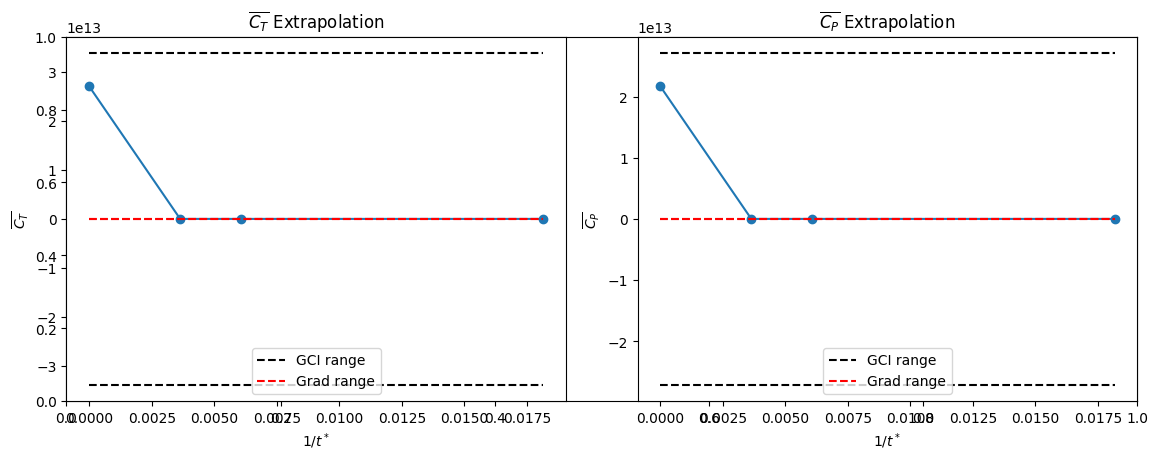

Extrapolated CT =  27072564377769.3
Extrapolated CP =  21658051664140.777
 
The error of final CT & CP with respect to their extrapolated values:
   Final CT average error =  100.0 %
   Final CP average error =  100.0 %
 
The suggested simulation time to reach  5 % error of the extrapolated value:
   Based on extrapolated CT =  1.33203112902189e+18  unit time
   Based on extrapolated CP =  1.332031139087582e+18  unit time


In [8]:
print("Extrapolating Data")
Total_Data2 = len(CT_Avg)
h = 1./Time_Data[Start_Index:Total_Data]
#Sampling_Points = [Total_Data2*50//100, Total_Data2*75//100, Total_Data2-1]    # 50%, 75%, 100%
Sampling_Points = [Total_Data2*20//100, Total_Data2*60//100, Total_Data2-1]    # 20%, 60%, 100%
h_Sample = [h[Sampling_Points[2]], h[Sampling_Points[1]], h[Sampling_Points[0]]]
CT_Sample = [CT_Avg[Sampling_Points[2]], CT_Avg[Sampling_Points[1]], CT_Avg[Sampling_Points[0]]]
CP_Sample = [CP_Avg[Sampling_Points[2]], CP_Avg[Sampling_Points[1]], CP_Avg[Sampling_Points[0]]]

# Order of accuracy
p_CT = p_Calc(h_Sample, CT_Sample)
p_CP = p_Calc(h_Sample, CP_Sample)

# Extrapolate
r12 = h_Sample[1] / h_Sample[0]
Error_Estimate_CT = (CT_Sample[1] - CT_Sample[0])/(r12 ** p_CT - 1)
Error_Estimate_CP = (CP_Sample[1] - CP_Sample[0])/(r12 ** p_CP - 1)

# Range
CT_Range_GCI = [CT_Sample[0] - 1.25 * Error_Estimate_CT, CT_Sample[0] + 1.25 * Error_Estimate_CT]
CP_Range_GCI = [CP_Sample[0] - 1.25 * Error_Estimate_CP, CP_Sample[0] + 1.25 * Error_Estimate_CP]
CT_Range_Grad = Calc_Range_Grad(h_Sample, CT_Sample)
CP_Range_Grad = Calc_Range_Grad(h_Sample, CP_Sample)

# Insert extrapolated point
h_Sample.insert(0, 0.)
CT_Sample.insert(0, CT_Sample[0] - Error_Estimate_CT)
CP_Sample.insert(0, CP_Sample[0] - Error_Estimate_CP)

# Calculating discrepancies between final CT and CP and their extrapolated values
err_final_CT = 100.*abs(CT_Sample[1]-CT_Sample[0])/CT_Sample[0]
err_final_CP = 100.*abs(CP_Sample[1]-CP_Sample[0])/CP_Sample[0]

# Estimated time needed to reach a certain percentage error of the extrapolated value. Default = 5% 
CT_est_time = np.ceil(abs((100.*(CT_Sample[1]-CT_Sample[0]))/(err_percent*CT_Sample[1]*h_Sample[1])))
CP_est_time = np.ceil(abs((100.*(CP_Sample[1]-CP_Sample[0]))/(err_percent*CP_Sample[1]*h_Sample[1])))

# Plot
plt.subplots(figsize=(12, 5))

plt.subplot(1, 2, 1)  # row 1, column 2, count 1
plt.plot(h_Sample, CT_Sample, marker = 'o')
plt.plot([0., h_Sample[3]], [CT_Range_GCI[0], CT_Range_GCI[0]], c = 'black', linestyle = 'dashed', label='GCI range')
plt.plot([0., h_Sample[3]], [CT_Range_GCI[1], CT_Range_GCI[1]], c = 'black', linestyle = 'dashed')
plt.plot([0., h_Sample[3]], [CT_Range_Grad[0], CT_Range_Grad[0]], c = 'r', linestyle = 'dashed', label='Grad range')
plt.plot([0., h_Sample[3]], [CT_Range_Grad[1], CT_Range_Grad[1]], c = 'r', linestyle = 'dashed')
plt.legend()
plt.title('$\overline{C_T}$ Extrapolation')
plt.xlabel('$1/t^*$')
plt.ylabel('$\overline{C_T}$')

plt.subplot(1, 2, 2)
plt.plot(h_Sample, CP_Sample, marker = 'o')
plt.plot([0., h_Sample[3]], [CP_Range_GCI[0], CP_Range_GCI[0]], c = 'black', linestyle = 'dashed', label='GCI range')
plt.plot([0., h_Sample[3]], [CP_Range_GCI[1], CP_Range_GCI[1]], c = 'black', linestyle = 'dashed')
plt.plot([0., h_Sample[3]], [CP_Range_Grad[0], CP_Range_Grad[0]], c = 'r', linestyle = 'dashed', label='Grad range')
plt.plot([0., h_Sample[3]], [CP_Range_Grad[1], CP_Range_Grad[1]], c = 'r', linestyle = 'dashed')
plt.legend()
plt.title('$\overline{C_P}$ Extrapolation')
plt.xlabel('$1/t^*$')
plt.ylabel('$\overline{C_P}$')

plt.tight_layout()
plt.show()

print("Extrapolated CT = ",CT_Sample[0])
print("Extrapolated CP = ",CP_Sample[0])
print(" ")
print("The error of final CT & CP with respect to their extrapolated values:")
print("   Final CT average error = ",round(err_final_CT,3),"%")
print("   Final CP average error = ",round(err_final_CP,3),"%")
print(" ")
print("The suggested simulation time to reach ", err_percent, "% error of the extrapolated value:")
if err_final_CT > err_percent:
    print("   Based on extrapolated CT = ", CT_est_time," unit time")
else:
    print("   The existing CT error is already <", err_percent,"%")  
if err_final_CP > err_percent:
    print("   Based on extrapolated CP = ", CP_est_time," unit time")
else:
    print("   The existing CP error is already <", err_percent,"%")  